
<!-- <img src="https://upload.wikimedia.org/wikipedia/commons/5/5d/UfcgBrasao.jpg" height=250 width=250> -->

# 🤖 Projeto de Inteligência Artificial - 01
---
 
## 💡 Otimização de Funções Heurísticas via Algoritmo Genético

> Utilizando Algoritmo genético para determinação de pesos para funções heurísticas, que serão utilizadas no algoritmo de busca A* para solucionar um jogo de 8-Puzzle (3x3) ou 15-Puzzle (4x4).

- Pedro Manoel Herminio Alves <br>
- Lucas Araujo de Lima <br>
- Luiz Gustavo Alves Nery <br>
- Felipe Oliveira da Silva <br>
- Vinicius Trindade Rocha Ribeiro <br>



## ⚙️ Instalação e Importação de Bibliotecas Necessárias

In [ ]:
!pip install pygad

import timeit # Será utilizada para calculo de tempo
import random # Será utilizada para geração de números aleatórios 
import copy # Será utilizada para fazer cópias das estruturas de dados do python
import math # Será utilizado para uso de funções matemáticas
import numpy as np # Será utilizado como auxílio para manipulação de listas
import matplotlib as mpl # Será utilizada para geração de gráficos
import matplotlib.pyplot as plt # Será utilizada para geração de gráficos
import pygad # Será utilizada no algoritmo genético
import termcolor # Será utilizado para coloração de textos 
from termcolor import colored # Será utilizado para coloração de textos 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.7 MB/s 


## 🎮 Implementação do Puzzle

Trata-se de um quebra-cabeças de peças, com quadrados que trocam de lugar, todos gravados com números, letras ou figuras. O objetivo é arranjar as peças em ordem, da esquerda para a direita, de cima para baixo.

<img src="https://camo.githubusercontent.com/59b1fbe9a5574e01cb73240f565a1a7cacd63385c81ba0fb74552fb5229c5fae/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f3932342f312a5978655a4a7a666857346b6e354f35774147626b49672e676966" height=150 width=150>

[Fonte](https://pt.wikipedia.org/wiki/O_jogo_do_15)

In [ ]:
class Puzzle:
  def __init__(self, dimensao=None, estadoInicial=None):
    if dimensao is None and estadoInicial is None:
        return RuntimeError('Puzzle não foi inicializado corretamente')

    self.dimensao = len(estadoInicial) if estadoInicial else dimensao
    self.estadoMeta = self.gerarEstadoMeta()
    self.estado = estadoInicial if estadoInicial else self.gerarEstadoInicialAleatorio()

  def __str__(self):
    if self.dimensao == 4:
        print("╔═══╦═══╦═══╦═══╗")
    else :
        print("╔═══╦═══╦═══╗")
    for i in range(self.dimensao):
        for j in range(self.dimensao):
            print("║ ",end="")
            if(self.estado[i][j] == 0) :
                print(" ", end= "")
            else :
                print(self.estado[i][j], end="")
            if(self.estado[i][j] < 10):
                print(" ", end="")
        print("║")
        if(i != self.dimensao-1):
            if self.dimensao == 4:
                print("╠═══╬═══╬═══╬═══╣")
            else :
                print("╠═══╬═══╬═══╣")
    if self.dimensao == 4:
        print("╚═══╩═══╩═══╩═══╝")
    else :
        print("╚═══╩═══╩═══╝")
    return ''

  # Geração de um estado inicial aleatório válido
  def gerarEstadoInicialAleatorio(self):
      estado = copy.deepcopy(self.estadoMeta)
      estadoLista = [j for i in estado for j in i]
      while True:
          random.shuffle(estadoLista)
          estado = [estadoLista[self.dimensao * i: self.dimensao+(self.dimensao*i)] for i in range(self.dimensao)]
          if self.isSolucionavel(estado) and estado != self.estadoMeta: 
              return estado

  # Geração do estado Meta
  def gerarEstadoMeta(self):
      estadoMeta = []
      novaLinha = []

      for i in range(1, self.dimensao * self.dimensao + 1):
          novaLinha.append(i)
          if len(novaLinha) == self.dimensao:
              estadoMeta.append(novaLinha)
              novaLinha = []

      estadoMeta[-1][-1] = 0
      return estadoMeta

  # Troca de posição entre dois elementos
  def swap(self, lin1, col1, lin2, col2):
      puzzleCopy = copy.deepcopy(self.estado)
      puzzleCopy[lin1][col1], puzzleCopy[lin2][col2] = puzzleCopy[lin2][col2], puzzleCopy[lin1][col1]

      return puzzleCopy

  # retorna a linha e a coluna de um determinado elemento
  def getCoordenadas(self, ele, estado=None):
      if not estado:
          estado = self.estado

      for i in range(self.dimensao):
          for j in range(self.dimensao):
              if estado[i][j] == ele:
                  return i, j

      return RuntimeError('Elemento inválido')

  def getLinhaEspaçoBrancoContandoBaixoCima(self, estado=None):
      linhaZero, _ = self.getCoordenadas(0, estado)  # espaço em branco
      return self.dimensao - linhaZero

  # Número de inversões
  def getNumInversoes(self, estado=None):
      if not estado:
          estado = self.estado

      count = 0
      puzzleList = [num for linha in estado for num in linha if num != 0]

      for i in range(len(puzzleList)):
          for j in range(i + 1, len(puzzleList)):
              if puzzleList[i] > puzzleList[j]:
                  count += 1

      return count


  # Gerar e retornar todos os puzzles (estados) possíveis de acordo com o puzzle atual (estado atual)
  def getPuzzlesPossiveis(self):
      puzzles = []
      lin, col = self.getCoordenadas(0)  # Posição do espaço em branco (número 0)

      if lin > 0:
          puzzles.append(Puzzle(self.dimensao, self.swap(lin, col, lin - 1, col)))  # move up

      if col < self.dimensao - 1:
          puzzles.append(Puzzle(self.dimensao, self.swap(lin, col, lin, col + 1)))  # move right

      if col > 0:
          puzzles.append(Puzzle(self.dimensao, self.swap(lin, col, lin, col - 1)))  # move left

      if lin < self.dimensao - 1:
          puzzles.append(Puzzle(self.dimensao, self.swap(lin, col, lin + 1, col)))  # move down

      return puzzles

  # 0. Dado que N é a dimensão do puzzle temos:
  # 1. Se N for ímpar, então a instância do quebra-cabeça é solucionável se o número de inversões for par no estado de entrada.
  # 2. Se N for par, a instância do quebra-cabeça é solucionável se
      # - o espaço em branco está em uma linha par, contando de baixo para cima (penúltimo, penúltimo, etc.)
      #   e o número de inversões é ímpar.
      # - o espaço em branco está em uma linha ímpar contando de baixo para cima (último, penúltimo, penúltimo, etc.)
      #   e o número de inversões é par.
  # 3. Para todos os outros casos, a instância do quebra-cabeça não pode ser resolvida.
  def isSolucionavel(self, estado=None):
      
      def isImpar(num):
          return num % 2 != 0
      
      def isPar(num):
          return num % 2 == 0

      numInversoes = self.getNumInversoes(estado)
      posicaoBranco = self.getLinhaEspaçoBrancoContandoBaixoCima(estado)

      if isImpar(self.dimensao) and isPar(numInversoes):
          return True
      elif isPar(self.dimensao) and isPar(posicaoBranco) and isImpar(numInversoes):
          return True
      elif isPar(self.dimensao) and isImpar(posicaoBranco) and isPar(numInversoes):
          return True
      else:
          return False

In [ ]:
class PuzzleSolver:
    def __init__(self, algoritmo):
        self.algoritmo = algoritmo
        self.tempo = 0

    def isSolucionado(self):
      return self.algoritmo.solucao != []

    def printPerformance(self):
        if self.isSolucionado():
          print(colored('\nSolucionado', 'green'))
          print(f'tempo: {self.tempo} segundos\nNós expandidos: {self.getNumNosExpandidos()}\nMovimentos: {self.getNumMovimentos()}')
        else:
          print(colored('\nFalhou', 'red'))
          print(f'tempo: {self.tempo} segundos\nNós expandidos: {self.getNumNosExpandidos()}')
        
    def printSolucao(self):
        if not self.isSolucionado():
          print(colored('\nNão foi possível encontrar uma solução', 'red'))
        else:
          print(colored('\nSolução:\n', 'green'))
          for i in range(len(self.getSolucao())):
            print(f'{i + 1}º Movimento')
            print(self.getSolucao()[i])
      
    def getSolucao(self):
      return self.algoritmo.solucao

    def getNumNosExpandidos(self):
      return self.algoritmo.numNosExpandidos

    def getNumMovimentos(self):
      return self.algoritmo.numMovimentos

    def resolver(self):
        if not self.algoritmo.puzzle.isSolucionavel():
            raise RuntimeError('Puzzle não é solucionável')

        startTime = timeit.default_timer()
        self.algoritmo.executar()
        self.tempo = timeit.default_timer() - startTime

In [ ]:
class PuzzleAnalise:

    def __init__(self, dimensao, maxNos, numAmostras, listHeuristics, listWeights=None, estadosIniciais=None):
      if dimensao is None and estadosIniciais is None:
        return RuntimeError('PuzzleAnalise não foi inicializado corretamente')

      self.dimensao = dimensao
      self.maxNos = maxNos
      self.numAmostras = numAmostras
      self.estadosIniciais = estadosIniciais
      self.listHeuristics = listHeuristics
      self.listWeights = listWeights
      self.tempos = [] 
      self.solucionados = [] 
      self.solucoes = [] 
      self.naoSolucionados = [] 
      self.movimentos = [] 
      self.nosExpandidos = [] 
      self.estadosIniciais = [] 
      
    def getMediaNosExpandidos(self):
      return round(sum(self.nosExpandidos)/len(self.nosExpandidos))

    def getMediaMovimentos(self):
      return round(sum(self.movimentos)/len(self.movimentos))

    def printPerformance(self):
        print(f'\nSolucionados: {len(self.solucoes)}\nFalhados: {len(self.naoSolucionados)}\n')
        print(f'Média nós expandidos: {self.getMediaNosExpandidos()}')
        print(f'Média movimentos: {self.getMediaMovimentos()}')

    def getAnalise(self):
      return self.tempos,self.solucionados,self.solucoes,self.naoSolucionados,self.movimentos,self.nosExpandidos 

    def run(self):
        for i in range(self.numAmostras):
            puzzle = Puzzle(self.estadosIniciais[i] if self.estadosIniciais else self.dimensao)
            puzzleSolver = PuzzleSolver(AStar(puzzle, self.maxNos, self.listHeuristics, self.listWeights, ))
            puzzleSolver.resolver()
            
            if puzzleSolver.isSolucionado():
                self.solucoes.append(puzzleSolver.getSolucao())
                self.solucionados.append((puzzleSolver.getSolucao(), puzzleSolver.getNumNosExpandidos()))
            else:
                self.naoSolucionados.append((puzzleSolver.getSolucao(), puzzleSolver.getNumNosExpandidos()))
            
            self.tempos.append(puzzleSolver.tempo)
            self.nosExpandidos.append(puzzleSolver.getNumNosExpandidos())
            self.movimentos.append(puzzleSolver.getNumMovimentos())
            puzzleSolver.printPerformance()
                    
    def plotGraphNosExpandidos(self):
        plt.rcParams['figure.figsize'] = (12, 6)
        plt.hist(self.nosExpandidos, 10, facecolor="g", alpha=0.75)
        plt.xlabel("Nós expandidos")
        plt.ylabel("Casos")
        plt.title("Histograma da Resolução do Puzzle")
        plt.grid(True)
        plt.show()
        
    def plotGraphMovimentos(self):
        plt.rcParams['figure.figsize'] = (12, 6)
        plt.hist(self.movimentos, 10, facecolor="g", alpha=0.75)
        plt.xlabel("Movimentos")
        plt.ylabel("Casos")
        plt.title("Histograma da Resolução do Puzzle")
        plt.grid(True)
        plt.show()

## 📎 Implementação da Busca A*

O Algoritmo A* é um algoritmo para Busca de Caminho. Ele busca o caminho em um grafo de um vértice inicial até um vértice final. Ele é a combinação de aproximações heurísticas como do algoritmo Breadth First Search (Busca em Largura) e da formalidade do Algoritmo de Dijkstra.

Sua aplicação vai desde aplicativos para encontrar rotas de deslocamento entre localidades a resolução de problemas, como a resolução de um quebra-cabeças.

<div style="display:block,margin-left:auto,margin-right:auto,width: 50%;">
  <img src="https://miro.medium.com/max/420/1*HppvOLfDxXqQRFn0Cv2dHQ.gif">
</div>



[Fonte](https://pt.wikipedia.org/wiki/Algoritmo_A*)

In [ ]:
class Algorithm:
    def __init__(self, puzzle, maxNos, listHeuristics, listWeights=None):
        self.puzzle = puzzle
        self.listHeuristics = listHeuristics
        self.listWeights = [1 for i in range(len(listHeuristics))] if listWeights is None else listWeights
        self.numNosExpandidos = 0
        self.numMovimentos = 0
        self.solucao = None
        self.maxNos = maxNos
        self.verificarHeuristicas()

    def verificarHeuristicas(self):
        for heuristica in self.listHeuristics:
           heuristica.test()

    def executar(self):
        raise NotImplementedError

    def __str__(self):
        return 'Algorithm'

In [ ]:
class AStar(Algorithm):    
    def __init__(self, puzzle, maxNos, listHeuristics, listWeights=None):
        super().__init__(puzzle, maxNos, listHeuristics, listWeights)

    def __str__(self):
        return 'A*'

    def calcularValorCusto(self, puzzleAtual, puzzleMeta = None):
        h = 0
        
        if puzzleMeta is None:
            for i in range(len(self.listHeuristics)):
                h += (self.listWeights[i] * self.listHeuristics[i].calculate(puzzleAtual))
        else:
            for i in range(len(self.listHeuristics)):
                h += (self.listWeights[i] * self.listHeuristics[i].calculate(puzzleAtual)) - (self.listWeights[i] * self.listHeuristics[i].calculate(puzzleMeta))

        return h

    def executar(self):
        fila = [[self.calcularValorCusto(self.puzzle), self.puzzle]]
        expandidos = []
        numNosExpandidos = 0
        caminho = None

        print('\n0', end='...')
        while fila:
            i = 0
            for j in range(1, len(fila)):
                if fila[i][0] > fila[j][0]:  # minimum
                    i = j

            caminho = fila[i]
            fila = fila[:i] + fila[i + 1:]
            noFinal = caminho[-1]

            if noFinal.estado == noFinal.estadoMeta:
                break
            if noFinal.estado in expandidos:
                continue

            for novoNo in noFinal.getPuzzlesPossiveis():
                if novoNo.estado in expandidos:
                    continue
                novoCaminho = [caminho[0] + self.calcularValorCusto(novoNo, noFinal)] + caminho[1:] + [novoNo]
                fila.append(novoCaminho)
                expandidos.append(noFinal.estado)

            numNosExpandidos += 1
            if (numNosExpandidos % (self.maxNos / 10) == 0): 
                print(numNosExpandidos, end="....")
            if numNosExpandidos > self.maxNos: 
                caminho = []
                break

        self.numNosExpandidos = numNosExpandidos
        self.solucao = caminho[1:]
        self.numMovimentos = len(self.solucao)

## 🔩 Implementação das Heurísticas

Uma função heurística, também chamada simplesmente de heurística, é uma função que classifica alternativas em algoritmos de pesquisa em cada etapa de ramificação com base nas informações disponíveis para decidir qual ramificação seguir. Por exemplo, pode aproximar a solução exata.

[Fonte](https://pt.wikipedia.org/wiki/Heur%C3%ADstica_(computa%C3%A7%C3%A3o)#:~:text=Uma%20fun%C3%A7%C3%A3o%20heur%C3%ADstica%2C%20tamb%C3%A9m%20chamada,pode%20aproximar%20a%20solu%C3%A7%C3%A3o%20exata.)

In [ ]:
class Heuristic:
    def __str__(self):
      return 'Heuristic' 

    def calculate(self):
      raise NotImplementedError

    def test(self):
      raise NotImplementedError

    @staticmethod
    def analise(dimensaoPuzzle, maxNos, numAmostras, listHeuristics, listWeights=None):
      listColor = ['red', 'blue', 'green', 'magenta', 'yellow']
      listWeights = [1 for i in range(len(listHeuristics))] if listWeights is None else listWeights

      plt.rcParams['figure.figsize'] = (14, 7)
      plt.title('Eficiência das Heurísticas') 
      plt.xlabel('Movimentos')
      plt.ylabel('Nós expandidos')
      
      estados = None

      for i in range(len(listH)):
        print(colored(f'\n===========================| {listHeuristics[i].__str__()} |========================================\n', 'cyan'))
        puzzleAnalise = PuzzleAnalise(dimensaoPuzzle, maxNos, numAmostras, [listHeuristics[i]], listWeights, estados)
        puzzleAnalise.run()
        _,_,solucoes,_,movimentos,nosExpandidos = puzzleAnalise.getAnalise()
        estados = [s[0].estado for s in solucoes]  if estados is None else estados
        movimentos.sort()
        nosExpandidos.sort()
        plt.plot(movimentos, nosExpandidos, color=listColor[i], label=listHeuristics[i].__str__())
      
      plt.legend(loc='upper left') 

### 🧮 Distância Euclidiana

Em matemática, distância euclidiana é a distância entre dois pontos, que pode ser provada pela aplicação repetida do teorema de Pitágoras. Aplicando essa fórmula como distância, o espaço euclidiano torna-se um espaço métrico.

\begin{align}
    \mathrm{d(x,y) = \sqrt[]{\sum_{i=1}^{k}\left( x_{i} - y_{i} \right)^2}}
\end{align}

[Fonte](https://pt.wikipedia.org/wiki/Dist%C3%A2ncia_euclidiana)

In [ ]:
class EuclideanDistance(Heuristic):
    def __str__(self):
      return 'EuclideanDistance'

    def calculate(self, puzzle):
        N = puzzle.dimensao
        estadoAtual = puzzle.estado
        estadoMeta = puzzle.estadoMeta
        dist = 0

        for i in range(N):
            for j in range(N):
                i2, j2 = puzzle.getCoordenadas(estadoAtual[i][j], estadoMeta)
                dist += math.sqrt(math.pow((i - i2), 2) + math.pow((j - j2), 2))
        
        return dist

    def test(self):
      assert self.calculate(Puzzle(None, [[1,2,3],[4,5,6],[7,8,0]])) == 0
      assert self.calculate(Puzzle(None, [[7,2,4],[5,0,6],[8,3,1]])) == 12.714776642118865
      assert self.calculate(Puzzle(None, [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]])) == 0
      assert self.calculate(Puzzle(None, [[8,15,6,0],[7,4,2,10],[14,1,11,9],[5,12,13,3]])) == 34.673745577623585

### 🧮 Distãncia de Manhattan

A distância de Manhattan (“City Block” ou
“Geometria do Táxi”) é uma forma de geometria
em que a usual métrica da geometria euclidiana
é substituída por uma nova métrica em que a
distância entre dois pontos é a soma das
diferenças absolutas de suas coordenadas.

\begin{align}
    \mathrm{d(x,y) = \sum_{i=1}^{k}\left| x_{i} - y_{i} \right|}
\end{align}

[Fonte](https://edisciplinas.usp.br/pluginfile.php/5309062/mod_resource/content/1/AM_Aula06.pdf#:~:text=A%20dist%C3%A2ncia%20de%20Manhattan%20(%E2%80%9CCity,diferen%C3%A7as%20absolutas%20de%20suas%20coordenadas.)

In [ ]:
class ManhattanDistance(Heuristic):

  def __str__(self):
    return 'ManhattanDistance'

  def calculate(self, puzzle):
    N = puzzle.dimensao
    estadoAtual = puzzle.estado
    estadoMeta = puzzle.estadoMeta
    dist = 0

    for i in range(N):
        for j in range(N):
            i2, j2 = puzzle.getCoordenadas(estadoAtual[i][j], estadoMeta)
            dist += abs(i - i2) + abs(j - j2)
    
    return dist

  def test(self):
    assert self.calculate(Puzzle(None, [[1,2,3],[4,5,6],[7,8,0]])) == 0    
    assert self.calculate(Puzzle(None, [[7,2,4],[5,0,6],[8,3,1]])) == 16
    assert self.calculate(Puzzle(None, [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]])) == 0
    assert self.calculate(Puzzle(None, [[8,15,6,0],[7,4,2,10],[14,1,11,9],[5,12,13,3]])) == 42

### 🧮 Distância de Minkowski

A distância de Minkowski é uma métrica em um espaço vetorial normado, a qual pode ser considerada como uma generalização de ambas as distâncias euclidiana e Manhattan.

\begin{align}
    \mathrm{d(x,y) = \left ( \sum_{i=1}^{k} \left | x_{i} - y_{i} \right |^p \right )^\frac{1}{p}}
\end{align}

[Fonte](https://en.wikipedia.org/wiki/Minkowski_distance)

In [ ]:
class MinkowskiDistance(Heuristic):

  def __init__(self, p):
    self.p = p

  def __str__(self):
    return 'MinkowskiDistance'

  def calculate(self, puzzle):
    N = puzzle.dimensao
    estadoAtual = puzzle.estado
    estadoMeta = puzzle.estadoMeta
    dist = 0

    for i in range(N):
        for j in range(N):
            i2, j2 = puzzle.getCoordenadas(estadoAtual[i][j], estadoMeta)
            dist += math.pow(math.pow(abs(i - i2), self.p) + math.pow(abs(j - j2), self.p), (1 / self.p))
        
    return dist

In [ ]:
class MinkowskiDistanceOrderOne(MinkowskiDistance):

    def __str__(self):
      return 'MinkowskiDistanceOrderOne'

    def __init__(self):
       super().__init__(1)

    def test(self):
      assert self.calculate(Puzzle(None, [[1,2,3],[4,5,6],[7,8,0]])) == 0 
      assert self.calculate(Puzzle(None, [[7,2,4],[5,0,6],[8,3,1]])) == 16
      assert self.calculate(Puzzle(None, [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]])) == 0
      assert self.calculate(Puzzle(None, [[8,15,6,0],[7,4,2,10],[14,1,11,9],[5,12,13,3]])) == 42

In [ ]:
class MinkowskiDistanceOrderTwo(MinkowskiDistance):

    def __str__(self):
      return 'MinkowskiDistanceOrderTwo'

    def __init__(self):
       super().__init__(2)

    def test(self):
      assert self.calculate(Puzzle(None, [[1,2,3],[4,5,6],[7,8,0]])) == 0 
      assert self.calculate(Puzzle(None, [[7,2,4],[5,0,6],[8,3,1]])) == 12.714776642118865
      assert self.calculate(Puzzle(None, [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]])) == 0
      assert self.calculate(Puzzle(None, [[8,15,6,0],[7,4,2,10],[14,1,11,9],[5,12,13,3]])) == 34.673745577623585

### 🧮 Fora do Lugar

Somatório do número de blocos (elementos) que não estão no local correto em comparação ao estado meta do puzzle.

In [ ]:
class OutOfPlace(Heuristic):
    
    def __str__(self):
      return 'OutOfPlace'

    def calculate(self, puzzle):
        N = puzzle.dimensao
        estadoAtual = puzzle.estado
        estadoMeta = puzzle.estadoMeta
        out = 0

        for i in range(N):
            for j in range(N):
                if estadoAtual[i][j] != estadoMeta[i][j]:
                    out += 1

        return out

    def test(self):
        assert self.calculate(Puzzle(None, [[1,2,3],[4,5,6],[7,8,0]])) == 0
        assert self.calculate(Puzzle(None, [[7,2,4],[5,0,6],[8,3,1]])) == 7
        assert self.calculate(Puzzle(None, [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]])) == 0
        assert self.calculate(Puzzle(None, [[8,15,6,0],[7,4,2,10],[14,1,11,9],[5,12,13,3]])) == 15

### 🧩 Instanciando Heurísticas


In [ ]:
h1 = EuclideanDistance()
h2 = ManhattanDistance()
h3 = MinkowskiDistanceOrderOne()
h4 = MinkowskiDistanceOrderTwo()
h5 = OutOfPlace()

### 📈 Análise da Eficiência de Heurísticas


===========================| EuclideanDistance |========================================


0...300....600....
Solucionado
tempo: 0.16618745599998874 segundos
Nós expandidos: 652
Movimentos: 51

0...300....600....
Solucionado
tempo: 0.17448582299994086 segundos
Nós expandidos: 672
Movimentos: 62

0...300....600....
Solucionado
tempo: 0.18298645699996996 segundos
Nós expandidos: 668
Movimentos: 68

0...300....600....
Solucionado
tempo: 0.3706745720000981 segundos
Nós expandidos: 693
Movimentos: 69

0...300....600....
Solucionado
tempo: 0.22768785700009175 segundos
Nós expandidos: 771
Movimentos: 69

0...300....600....
Solucionado
tempo: 0.15135146500006158 segundos
Nós expandidos: 606
Movimentos: 66

0...300....600....
Solucionado
tempo: 0.2235349759998826 segundos
Nós expandidos: 758
Movimentos: 97

0...300....600....
Solucionado
tempo: 0.179412548000073 segundos
Nós expandidos: 630
Movimentos: 48

0...300....600....
Solucionado
tempo: 0.18933285699995395 segundos
Nós expandidos: 672
M

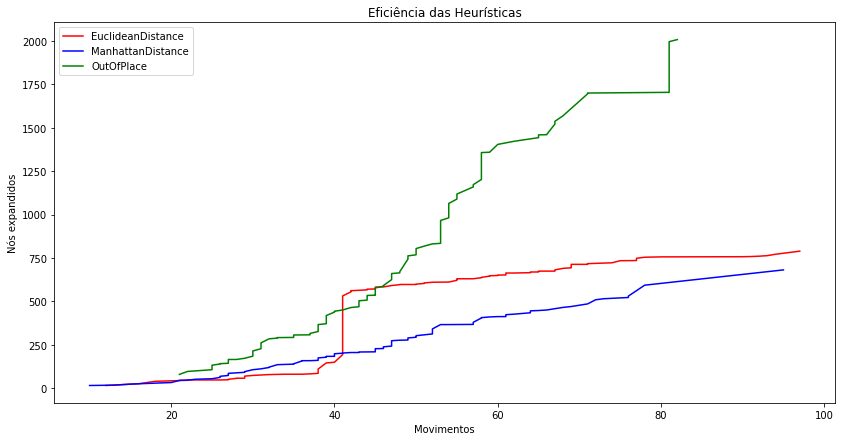

In [ ]:
dimensaoPuzzle = 3
maxNos = 3000
numAmostras = 100
listH = [h1, h2, h5]

Heuristic.analise(dimensaoPuzzle, maxNos, numAmostras, listH)

## 🎈 Funcionamento A* com Heurísticas (1 Amostra)

### 🚀 Execução

In [ ]:
dimensaoPuzzle = 4
maxNos = 6000

puzzle = Puzzle(dimensaoPuzzle)

listH = [ h2 ]

puzzleSolver = PuzzleSolver(AStar(puzzle, maxNos, listH))
puzzleSolver.resolver()
puzzleSolver.printPerformance()
puzzleSolver.printSolucao()


0...600....1200....1800....2400....3000....3600....4200....
Solucionado
tempo: 9.654679307999686 segundos
Nós expandidos: 4342
Movimentos: 144

Solução:

1º Movimento
╔═══╦═══╦═══╦═══╗
║ 1 ║ 2 ║ 3 ║ 4 ║
╠═══╬═══╬═══╬═══╣
║ 8 ║ 5 ║ 9 ║ 11║
╠═══╬═══╬═══╬═══╣
║ 10║ 6 ║ 13║   ║
╠═══╬═══╬═══╬═══╣
║ 7 ║ 12║ 15║ 14║
╚═══╩═══╩═══╩═══╝

2º Movimento
╔═══╦═══╦═══╦═══╗
║ 1 ║ 2 ║ 3 ║ 4 ║
╠═══╬═══╬═══╬═══╣
║ 8 ║ 5 ║ 9 ║ 11║
╠═══╬═══╬═══╬═══╣
║ 10║ 6 ║   ║ 13║
╠═══╬═══╬═══╬═══╣
║ 7 ║ 12║ 15║ 14║
╚═══╩═══╩═══╩═══╝

3º Movimento
╔═══╦═══╦═══╦═══╗
║ 1 ║ 2 ║ 3 ║ 4 ║
╠═══╬═══╬═══╬═══╣
║ 8 ║ 5 ║ 9 ║ 11║
╠═══╬═══╬═══╬═══╣
║ 10║   ║ 6 ║ 13║
╠═══╬═══╬═══╬═══╣
║ 7 ║ 12║ 15║ 14║
╚═══╩═══╩═══╩═══╝

4º Movimento
╔═══╦═══╦═══╦═══╗
║ 1 ║ 2 ║ 3 ║ 4 ║
╠═══╬═══╬═══╬═══╣
║ 8 ║ 5 ║ 9 ║ 11║
╠═══╬═══╬═══╬═══╣
║ 10║ 12║ 6 ║ 13║
╠═══╬═══╬═══╬═══╣
║ 7 ║   ║ 15║ 14║
╚═══╩═══╩═══╩═══╝

5º Movimento
╔═══╦═══╦═══╦═══╗
║ 1 ║ 2 ║ 3 ║ 4 ║
╠═══╬═══╬═══╬═══╣
║ 8 ║ 5 ║ 9 ║ 11║
╠═══╬═══╬═══╬═══╣
║ 10║ 12║ 6 ║ 13║
╠═══╬═══╬═══╬═══╣
║ 

## 🎈 Funcionamento A* com Heurísticas (N Amostras)

### 🚀 Execução

In [ ]:
dimensaoPuzzle = 3
maxNos = 3000
numAmostras = 100

listH = [ h2 ]

puzzleAnalise = PuzzleAnalise(dimensaoPuzzle, maxNos, numAmostras, listH)
puzzleAnalise.run()


0...300....
Solucionado
tempo: 0.10684695900090446 segundos
Nós expandidos: 487
Movimentos: 54

0...
Solucionado
tempo: 0.01422385700061568 segundos
Nós expandidos: 91
Movimentos: 35

0...
Solucionado
tempo: 0.03591802600021765 segundos
Nós expandidos: 150
Movimentos: 48

0...
Solucionado
tempo: 0.029218257001048187 segundos
Nós expandidos: 192
Movimentos: 37

0...300....
Solucionado
tempo: 0.08221085399964068 segundos
Nós expandidos: 375
Movimentos: 59

0...
Solucionado
tempo: 0.023007576000964036 segundos
Nós expandidos: 154
Movimentos: 31

0...
Solucionado
tempo: 0.04560196499915037 segundos
Nós expandidos: 272
Movimentos: 65

0...
Solucionado
tempo: 0.012112442000216106 segundos
Nós expandidos: 85
Movimentos: 19

0...
Solucionado
tempo: 0.03867008099950908 segundos
Nós expandidos: 236
Movimentos: 42

0...
Solucionado
tempo: 0.029674977999093244 segundos
Nós expandidos: 176
Movimentos: 43

0...
Solucionado
tempo: 0.046683249000125215 segundos
Nós expandidos: 262
Movimentos: 47

0..

### 📈 Peformance e Gráficos


Solucionados: 100
Falhados: 0

Média nós expandidos: 261
Média movimentos: 48


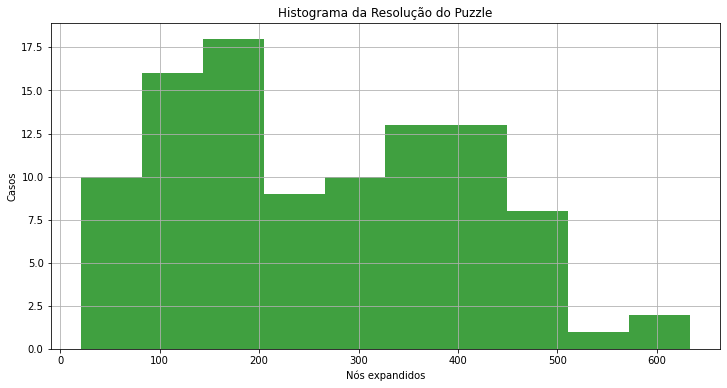

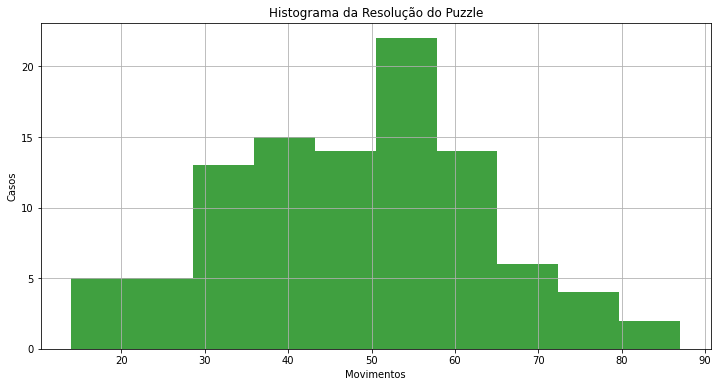

In [ ]:
puzzleAnalise.printPerformance()
puzzleAnalise.plotGraphNosExpandidos()
print()
puzzleAnalise.plotGraphMovimentos()

## 🧬 Algoritmo Genético

Algoritmos Genéticos são inspirados no princípio
Darwiniano da evolução das espécies e na genética.
São algoritmos probabilísticos que fornecem
um mecanismo de busca paralela e adaptativa
baseado no princípio de sobrevivência dos mais
aptos e na reprodução. 

<img src="https://sites.icmc.usp.br/andre/research/genetic/image/cross_an.gif">

[Fonte](http://www.inf.ufsc.br/~mauro.roisenberg/ine5377/Cursos-ICA/CE-intro_apost.pdf)

#### 🚀 Execução

In [ ]:
listH = [ h1, h2, h5 ]

In [ ]:
dimensaoPuzzle = 3
maxNos = 3000

def callback_generation(ga_instance):
    print(f'\n\n{ga_instance.generations_completed}º Geração\n')
    print(f'\n\nSolução: {ga_instance.best_solution()[0]}\n')

def fitness(solution, solution_idx):
  puzzle = Puzzle(dimensaoPuzzle)
  puzzleSolver = PuzzleSolver(AStar(puzzle, maxNos, listH, solution))
  puzzleSolver.resolver()

  if puzzleSolver.isSolucionado():
    return 1/(puzzleSolver.getNumNosExpandidos() * puzzleSolver.getNumMovimentos())
  else:
    return -999999999

# Número de gerações
num_generations = 50

# Número de soluções a serem selecionadas como pais
num_parents_mating = 2

# Número de soluções (ou seja, cromossomos) dentro da população
sol_per_pop = 50 

# Número de genes na solução/cromossomo
num_genes = len(listH)

# O valor mais baixo do intervalo aleatório do qual os valores dos genes na população inicial são selecionados
init_range_low = -2

# O valor superior do intervalo aleatório a partir do qual os valores dos genes na população inicial são selecionados
init_range_high = 5

# Criando uma instância da pygad.GA
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=fitness,
                       sol_per_pop=sol_per_pop, 
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       on_generation=callback_generation)

# Executando
ga_instance.run()

# Atribuindo a melhor solução a variáveis
solution, solution_fitness, solution_idx = ga_instance.best_solution()

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:473: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


A saída de streaming foi truncada nas últimas 5000 linhas.
0...
0...
0...300....600....900....1200....1500....1800....2100....2400....2700....
0...300....600....900....1200....1500....1800....2100....2400....2700....3000....
0...
0...
0...

3º Geração


0...300....
0...
0...300....600....900....1200....1500....1800....2100....2400....2700....3000....
0...
0...
0...300....
0...
0...
0...
0...
0...
0...
0...300....600....900....1200....1500....1800....2100....2400....2700....3000....
0...
0...300....600....900....1200....1500....1800....2100....2400....2700....3000....
0...
0...300....600....900....1200....1500....1800....2100....2400....2700....3000....
0...
0...
0...
0...
0...
0...300....
0...
0...
0...
0...300....600....900....1200....1500....1800....2100....2400....2700....3000....
0...
0...
0...
0...300....600....900....1200....1500....1800....2100....2400....2700....3000....
0...300....600....900....
0...300....
0...
0...
0...
0...300....600....900....1200....1500....1800....2100..

#### 📈 Resultados e Gráficos


Melhor solução: [-0.94365028  2.502043   -0.58786265]



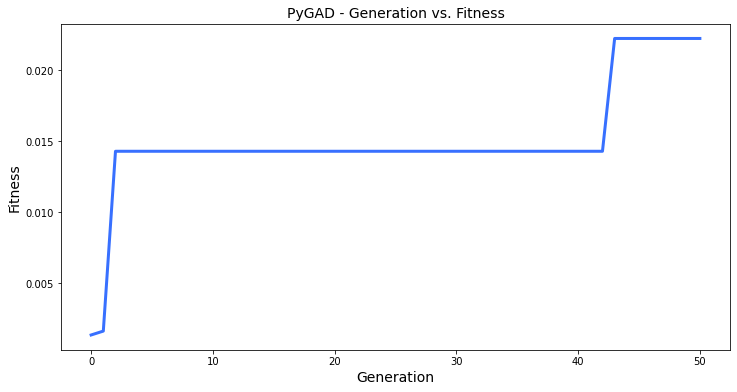

In [ ]:
print(f'\nMelhor solução: {solution}\n')

_ = ga_instance.plot_fitness()

## 🎈 Funcionamento A* com Heurísticas e AG (1 Amostra)


In [ ]:
dimensaoPuzzle = 3
maxNos = 3000
listWAG = solution

puzzle = Puzzle(dimensaoPuzzle)

print(colored('\n===========================| A* Normal |========================================\n', 'cyan'))
puzzleSolver = PuzzleSolver(AStar(puzzle, maxNos, listH))
puzzleSolver.resolver()
puzzleSolver.printPerformance()
#puzzleSolver.printSolucao()

print(colored('\n===========================| A* com AG |========================================\n', 'cyan'))
puzzleSolver = PuzzleSolver(AStar(puzzle, maxNos, listH, listWAG))
puzzleSolver.resolver()
puzzleSolver.printPerformance()
#puzzleSolver.printSolucao()


===========================| A* Normal |========================================


0...300....600....
Solucionado
tempo: 0.22010347099967476 segundos
Nós expandidos: 643
Movimentos: 64

===========================| A* com AG |========================================


0...
Solucionado
tempo: 0.060865944000397576 segundos
Nós expandidos: 246
Movimentos: 54


## 🎈 Funcionamento A* com Heurísticas e AG (N Amostras)



#### 🚀 Execução

In [ ]:
dimensaoPuzzle = 3
maxNos = 3000
numAmostras = 300
listWAG = solution

print(colored('\n===========================| A* Normal |========================================\n', 'cyan'))
puzzleAnaliseNormal = PuzzleAnalise(dimensaoPuzzle, maxNos, numAmostras, listH)
puzzleAnaliseNormal.run()
_,_,solucoesNormal,_,movimentosNormal,nosExpandidosNormal = puzzleAnaliseNormal.getAnalise()
estados = [s[0].estado for s in solucoesNormal]

print(colored('\n===========================| A* com AG |========================================\n', 'cyan'))
puzzleAnaliseAG = PuzzleAnalise(dimensaoPuzzle, maxNos, numAmostras, listH, listWAG, estados)
puzzleAnaliseAG.run()
_,_,_,_,movimentosAG,nosExpandidosAG = puzzleAnaliseAG.getAnalise()


===========================| A* Normal |========================================


0...300....
Solucionado
tempo: 0.18070896300014283 segundos
Nós expandidos: 568
Movimentos: 74

0...300....600....
Solucionado
tempo: 0.19526792000010573 segundos
Nós expandidos: 613
Movimentos: 75

0...
Solucionado
tempo: 0.012562973000058264 segundos
Nós expandidos: 52
Movimentos: 28

0...
Solucionado
tempo: 0.026851329000010082 segundos
Nós expandidos: 118
Movimentos: 57

0...300....600....
Solucionado
tempo: 0.26106821000007585 segundos
Nós expandidos: 747
Movimentos: 93

0...300....
Solucionado
tempo: 0.1614903659999527 segundos
Nós expandidos: 533
Movimentos: 67

0...300....
Solucionado
tempo: 0.1963446009999643 segundos
Nós expandidos: 494
Movimentos: 79

0...300....
Solucionado
tempo: 0.15366643599986674 segundos
Nós expandidos: 502
Movimentos: 78

0...
Solucionado
tempo: 0.019121147999840105 segundos
Nós expandidos: 80
Movimentos: 33

0...300....
Solucionado
tempo: 0.13757632500005457 segundos


#### 📈 Peformance e Gráficos


===========================| A* Normal |========================================


Solucionados: 300
Falhados: 0

Média nós expandidos: 429
Média movimentos: 61


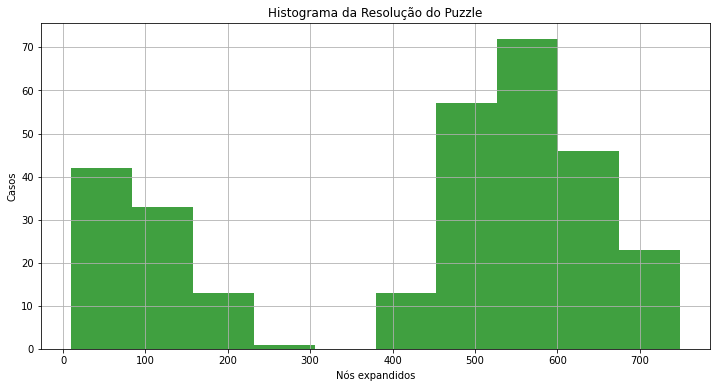


===========================| A* com AG |========================================


Solucionados: 300
Falhados: 0

Média nós expandidos: 224
Média movimentos: 54


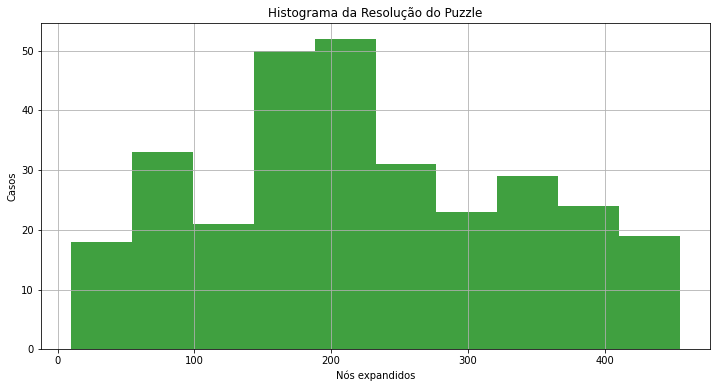


===========================| Análise Final |========================================



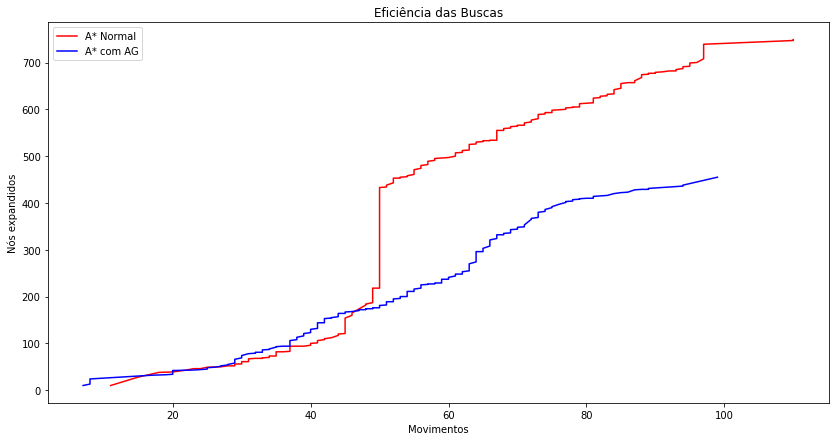

In [ ]:
print(colored('\n===========================| A* Normal |========================================\n', 'cyan'))
puzzleAnaliseNormal.printPerformance()
puzzleAnaliseNormal.plotGraphNosExpandidos()

print(colored('\n===========================| A* com AG |========================================\n', 'cyan'))
puzzleAnaliseAG.printPerformance()
puzzleAnaliseAG.plotGraphNosExpandidos()

plt.rcParams['figure.figsize'] = (14, 7)
plt.title('Eficiência das Buscas') 
plt.xlabel('Movimentos')
plt.ylabel('Nós expandidos')

print(colored('\n===========================| Análise Final |========================================\n', 'cyan'))

movimentosNormal.sort()
nosExpandidosNormal.sort()
movimentosAG.sort()
nosExpandidosAG.sort()

_ = plt.plot(movimentosNormal, nosExpandidosNormal, color='red', label='A* Normal')
_ = plt.plot(movimentosAG, nosExpandidosAG, color='blue', label='A* com AG')
_ = plt.legend(loc='upper left')
 